# Analyse Bestellbeziehungen

In [7]:
import pandas as pd
from collections import Counter, defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np # Für bessere Skalierung der Liniendicke

# Daten einlesen aus WAPOS
path = r'/home/michael/Dokumente/Repo/Notebook_Snippets/wapos_testdaten.csv'
df = pd.read_csv(path, sep=';')

# Annahme: df hat mindestens die Spalten 'AUFTRAGSNR' und 'ARTIKELNR'
# --- ARTIKEL-KOMBINATIONEN BERECHNEN ---
artikel_je_auftrag = defaultdict(list)
for auftrag, artikel in zip(df['AUFTRAGSNR'], df['ARTIKELNR']):
    artikel_je_auftrag[auftrag].append(artikel)

# Reverse Mapping: Welche Aufträge enthalten welchen Artikel?
auftrag_je_artikel = defaultdict(list)
for artikel, auftrag in zip(df['ARTIKELNR'], df['AUFTRAGSNR']):
    auftrag_je_artikel[artikel].append(auftrag)


def artikel_kombinationen(artikelnummer):
# Für einen gegebenen Artikel, finde alle anderen Artikel,
# die zusammen mit ihm in Aufträgen vorkommen.
    artikel_counter = Counter()
    auftraege = auftrag_je_artikel[artikelnummer]
    for auftrag in auftraege:
        artikel_liste = artikel_je_auftrag[auftrag]
        for artikel in artikel_liste:
            if artikel != artikelnummer:
                artikel_counter[artikel] += 1
    return artikel_counter.most_common()

# Das Ergebnis-Dictionary wird erstellt
artikel_beziehungen = defaultdict(list)
for artikel in df['ARTIKELNR'].unique():
    kombinationen = artikel_kombinationen(artikel)
    artikel_beziehungen[artikel] = kombinationen

# .items() liefert (Key, Value) Paare, [:100] schneidet die Liste
top_100_beziehungen = dict(list(artikel_beziehungen.items())[:100])

df.describe()



,_Id,AUFTRAGSNR,MANDANT,AUFTRAGSPOS,ZUSTAND,MENGE_SOLL,MENGE_IST,FREIGABE_DATUM,FREIGABE_ZEIT,FREIGABE_USR,...,TEXT3,TEXT4,TEXT5,GES_GEW,TEXT6,TEXT7,TEXT8,TEXT9,TEXT10,KOM_TEXT
count,2.380500e+04,2.380500e+04,23805.000000,23805.000000,23805.0,23805.000000,23805.0,0.0,0.0,0.0,...,0.0,0.0,0.0,23805.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,2.079959e+07,6.401332e+07,160.220038,1212.477085,10.0,32.891787,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
std,4.103555e+04,2.305495e+08,15.224864,916.128221,0.0,464.388729,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
min,2.023068e+07,3.646086e+07,30.000000,1.000000,10.0,1.000000,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.078642e+07,3.706368e+07,162.000000,400.000000,10.0,2.000000,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.082016e+07,3.706603e+07,162.000000,1040.000000,10.0,5.000000,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.083152e+07,3.707003e+07,162.000000,1910.000000,10.0,16.000000,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
max,2.085073e+07,2.080042e+09,162.000000,3290.000000,10.0,60000.000000,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## Graph erstellen

In [ ]:
# -------------------------------------------------
# --- NEUER TEIL: GRAPH ERSTELLEN & VISUALISIEREN ---
# -------------------------------------------------

# 1. Initialisiere den Graphen
G = nx.Graph()

# -------------------------------------------------
# WICHTIG: Filterung gegen "Hairball"-Effekt
# -------------------------------------------------
# Wenn du zu viele Daten hast, wird der Graph unlesbar.
# Setze einen Schwellenwert: Nur Kombinationen anzeigen,
# die mindestens MIN_ANZAHL mal vorgekommen sind.
MIN_ANZAHL = 25  # Passe diesen Wert an deine Datenmenge an! 
# Bei echten Daten vielleicht eher 10, 50 oder 100.

print(f"Erstelle Graph... (Filter: Mindestens {MIN_ANZAHL} gemeinsame Käufe)")

# 2. Daten aus deinem Dictionary in den Graphen laden
for haupt_artikel, relations_liste in top_100_beziehungen.items():
    for verwandter_artikel, anzahl in relations_liste:
        if anzahl >= MIN_ANZAHL:
            # Füge eine Kante hinzu. NetworkX kümmert sich automatisch darum,
            # dass die Verbindung (A, B) dieselbe ist wie (B, A).
            # Das 'weight' Attribut speichert die Häufigkeit.
            G.add_edge(haupt_artikel, verwandter_artikel, weight=anzahl)

# Prüfen, ob nach dem Filtern noch Knoten übrig sind
if len(G.nodes) == 0:
    print("Keine Daten nach Filterung übrig. Senke MIN_ANZAHL.")
else:
    print(f"Graph erstellt mit {len(G.nodes)} Artikeln und {len(G.edges)} Verbindungen.")

    # 3. Layout berechnen (Positionierung der Knoten)
    # 'spring_layout' versucht, verbundene Knoten nah beieinander zu halten.
    # k: Abstandsfaktor. Kleiner = engere Cluster. Größer = weiter verteilt.
    # seed: Sorgt dafür, dass das Layout bei jedem Ausführen gleich aussieht.
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

    plt.figure(figsize=(14, 10)) # Große Zeichenfläche

    # 4. Liniendicke basierend auf Gewicht berechnen
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    
    # Skalierung der Dicke, damit Linien nicht zu fett werden
    # Wir nutzen Logarithmus, um extreme Unterschiede abzufedern,
    # oder eine einfache lineare Skalierung:
    if weights:
        max_weight = max(weights)
        # Dicke zwischen 0.5 und 5, je nach relativem Gewicht
        widths = [(w / max_weight * 4.5) + 0.5 for w in weights]
    else:
        widths = 1

    # 5. Zeichnen der Komponenten
    # Knoten
    nx.draw_networkx_nodes(G, pos, 
                           node_size=800, 
                           node_color='skyblue', 
                           edgecolors='navy', # Dunkler Rand um Knoten
                           alpha=0.8)

    # Kanten (Linien) mit variabler Dicke
    nx.draw_networkx_edges(G, pos, 
                           width=widths, 
                           edge_color='gray', 
                           alpha=0.6)

    # Labels (Artikelnummern)
    # Um Überlappung zu vermeiden, kann man font_size verkleinern
    nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif')

    plt.title(f'Artikel-Kombinationen (Min. {MIN_ANZAHL} gemeinsame Käufe)')
    plt.axis('off') # Achsen verstecken
    plt.tight_layout()
    plt.show()

## Artikel die in Kombination auftreten

In [10]:
from itertools import combinations
from collections import Counter

def top_kombinationen_global(artikel_je_auftrag, top_n=10):
    paar_counter = Counter()

    # Wir gehen durch jeden einzelnen Auftrag
    for _, artikel_liste in artikel_je_auftrag.items():
        # Wir entfernen Duplikate innerhalb eines Auftrags (falls vorhanden)
        einzigartige_artikel = sorted(list(set(artikel_liste)))
        
        # combinations(liste, 2) erzeugt alle möglichen Paare: (A, B), (A, C), (B, C)...
        for paar in combinations(einzigartige_artikel, 2):
            paar_counter[paar] += 1

    return paar_counter.most_common(top_n)

# Anwendung:
top_kombis = top_kombinationen_global(artikel_je_auftrag, 10)

df_top = pd.DataFrame(
    [(p[0], p[1], count) for p, count in top_kombis],
    columns=['Artikel_1', 'Artikel_2', 'Anzahl_Käufe']
)
print(df_top)

        Artikel_1       Artikel_2  Anzahl_Käufe
0  03303900ET0001  07299700ET0005            26
1  03303900ET0001  08644500ET0001            25
2  07299700ET0005  08644500ET0001            25
3  03303900ET0001  04329740ET0001            22
4  04329740ET0001  07299700ET0005            22
5  04329740ET0001  08644500ET0001            22
6  02285320ET0001  03303900ET0001            20
7  02285320ET0001  07299700ET0005            20
8  02285320ET0001  08644500ET0001            20
9  03062200ET0001  03234800ET0003            18


## Artikel für Abdeckung n% der Aufträge

Gesamtanzahl Aufträge: 292
Ziel: 29 Aufträge (80%) komplett bedienen.

ERGEBNIS:
Du brauchst die Top 3211 Artikel.
Das sind 43.0% deines Sortiments.
Damit bedienst du 30 Aufträge (10.27%).


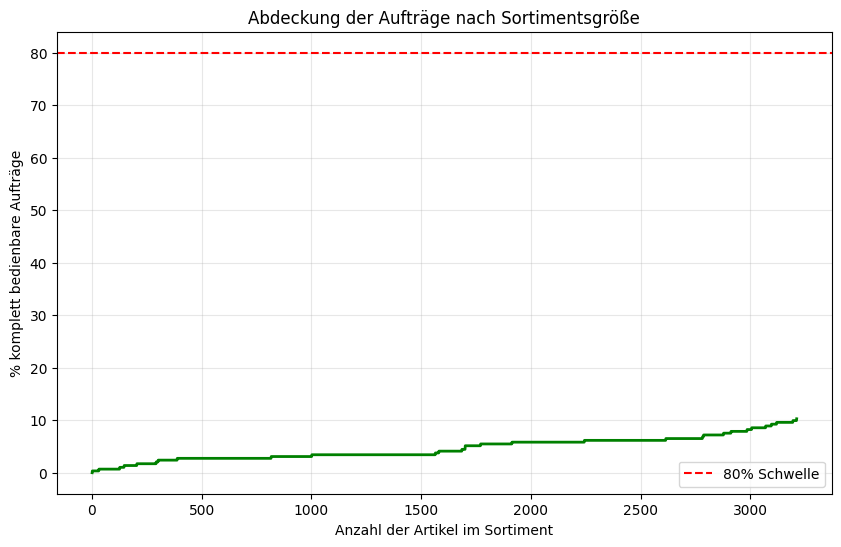

In [6]:
import pandas as pd

def berechne_80_prozent_abdeckung(df, artikel_je_auftrag):
    # 1. Ranking erstellen: Wie oft kommt jeder Artikel insgesamt vor?
    # (Häufige Artikel haben die höchste Chance, viele Aufträge zu vervollständigen)
    artikel_ranking = df['ARTIKELNR'].value_counts().index.tolist()
    
    gesamt_anzahl_auftraege = len(artikel_je_auftrag)
    ziel_abdeckung = 0.1
    anzahl_benötigter_auftraege = gesamt_anzahl_auftraege * ziel_abdeckung
    
    # Vorbereitung für die Simulation
    auftraege_sets = {id: set(art) for id, art in artikel_je_auftrag.items()}
    verfügbare_artikel = set()
    abgedeckte_auftraege_count = 0
    ergebnis_kurve = []

    print(f"Gesamtanzahl Aufträge: {gesamt_anzahl_auftraege}")
    print(f"Ziel: {anzahl_benötigter_auftraege:.0f} Aufträge (80%) komplett bedienen.\n")

    # 2. Schrittweise Artikel zum "Lager" hinzufügen
    for i, artikel in enumerate(artikel_ranking, 1):
        verfügbare_artikel.add(artikel)
        
        # Prüfen, welche Aufträge jetzt NEU komplett bedient werden können
        # Wir prüfen nur die Aufträge, die bisher noch nicht abgedeckt waren
        aktuell_abgedeckt = 0
        # Optimierung: Wir zählen alle Aufträge, deren Artikel-Set eine Teilmenge 
        # unserer verfügbaren Artikel ist
        for auftrag_id in list(auftraege_sets.keys()):
            if auftraege_sets[auftrag_id].issubset(verfügbare_artikel):
                aktuell_abgedeckt += 1
                # Optional: Auftrag aus der Liste löschen, um Geschwindigkeit zu erhöhen
                del auftraege_sets[auftrag_id]
        
        abgedeckte_auftraege_count += aktuell_abgedeckt
        prozent = (abgedeckte_auftraege_count / gesamt_anzahl_auftraege) * 100
        ergebnis_kurve.append(prozent)
        
        # 3. Zielprüfung
        if abgedeckte_auftraege_count >= anzahl_benötigter_auftraege:
            print(f"ERGEBNIS:")
            print(f"Du brauchst die Top {i} Artikel.")
            print(f"Das sind {(i / len(artikel_ranking) * 100):.1f}% deines Sortiments.")
            print(f"Damit bedienst du {abgedeckte_auftraege_count} Aufträge ({prozent:.2f}%).")
            break
            
    return artikel_ranking[:i], ergebnis_kurve

# Ausführung
top_artikel_80, verlauf = berechne_80_prozent_abdeckung(df, artikel_je_auftrag)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(verlauf) + 1), verlauf, color='green', linewidth=2)
plt.axhline(y=80, color='r', linestyle='--', label='80% Schwelle')
plt.xlabel('Anzahl der Artikel im Sortiment')
plt.ylabel('% komplett bedienbare Aufträge')
plt.title('Abdeckung der Aufträge nach Sortimentsgröße')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()